In [271]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [272]:
img_path = '/content/drive/MyDrive/Colab Notebooks/BEP/그림1.jpg'
# img_path = '/content/drive/MyDrive/Colab Notebooks/BEP/doberman.png'

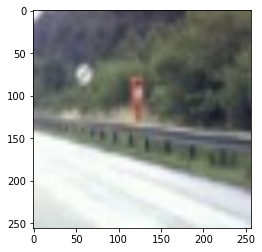

In [273]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

# 함수

In [274]:
sum(img[0][0])

760

In [275]:
def Gaussian_pyramid(img, n):
    G = img.copy()
    gpA = [G]
    for i in range(n):
        G = cv2.pyrDown(G)
        gpA.append(G)
    return gpA

def ptp_subtraction(img1, img2):
    img2 = cv2.resize(img2, img1.T.shape, interpolation = cv2.INTER_LINEAR).astype(np.int32)
    return (img1 - img2).clip(0)

def CS_diff(img):
    fmap = []
    gpA = Gaussian_pyramid(img, 9)
    fm1 = [2, 2, 3, 3, 4, 4]
    fm2 = [5, 6, 6, 7, 7, 8]
    for i in range(6): 
        psmap = ptp_subtraction(gpA[fm1[i]], gpA[fm2[i]])
        fmap.append(psmap)
    return fmap

def CS_diff2(img1, img2):
    fmap = []
    gpA1 = Gaussian_pyramid(img1, 9)
    gpA2 = Gaussian_pyramid(img2, 9)
    fm1 = [2, 2, 3, 3, 4, 4]
    fm2 = [5, 6, 6, 7, 7, 8]
    for i in range(6): 
        i1 = gpA1[fm1[i]] - gpA2[fm1[i]]
        i2 = gpA2[fm2[i]] - gpA1[fm2[i]]
        psmap = ptp_subtraction(i1, i2)
        fmap.append(psmap)

    return fmap

def intensity_map(img):
    il, jl, _= img.shape
    intensity = np.zeros((il, jl), dtype=float)
    for i in range(il):
        for j in range(jl):
            intensity[i][j] = sum(img[i][j])/3
    return [intensity]

def RGBY(img1, img2):
    return abs(((img1 - img2) - (img2 - img1)).clip(0))

def color_map(img):
    il, jl, _= img.shape
    r = lambda r, g, b : r - (g+b)/2
    g = lambda r, g, b : g - (r+b)/2
    b = lambda r, g, b : b - (r+g)/2
    y = lambda r, g, b : (r+g)/2 - abs(r-g)/2 - b
    R = np.zeros((il, jl), dtype=float)
    G = np.zeros((il, jl), dtype=float)
    B = np.zeros((il, jl), dtype=float)
    Y = np.zeros((il, jl), dtype=float)
    for i in range(il):
        for j in range(jl):
            Rr = img[i][j][0]
            Gg = img[i][j][1]
            Bb = img[i][j][2]
            R[i][j] = r(Rr, Gg, Bb)
            G[i][j] = g(Rr, Gg, Bb)
            B[i][j] = b(Rr, Gg, Bb)
            Y[i][j] = y(Rr, Gg, Bb) 
    R = R.clip(0)
    G = G.clip(0)
    B = B.clip(0)
    Y = Y.clip(0)
    return R, G, B, Y

def orientation_map(img):
    pi = math.pi/4
    thetha = [0, pi, pi*2, pi*3]
    filters = []
    o_imgs = []
    for o in thetha:
        filter = cv2.getGaborKernel((60, 60), 5, o, pi*8, 1, 0, cv2.CV_32F)
        filter /= math.sqrt((filter * filter).sum())
        filters.append(filter)
    for f in filters:
        o_imgs.append(cv2.cvtColor(cv2.filter2D(img, -1, f), cv2.COLOR_RGB2GRAY))
    return o_imgs

def cal_feature(maps):
    feature_map = []
    for map in maps:
        feature_map.append(CS_diff(map))
    return feature_map

def extract_features(img):
    i_map = intensity_map(img)
    R, G, B, Y = color_map(img)
    c_map = [CS_diff2(R, G), CS_diff2(B, Y)]
    o_map = orientation_map(img)

    return [c_map, cal_feature(i_map), cal_feature(o_map)]    

def local_max(features):
    local_max = []
    for fmap in features:
        local_max.append(np.max(fmap))
    return local_max

def find_max(features):
    lmax = []
    for i in features:
        for j in i:
            lmax.append(local_max(j))
    gmax = max(max(lmax))
    return lmax, gmax

def normalization(features, lmax, gmax):

    norm_feature = []
    # for i, fmap in enumerate(features):
    #     norm = pow((gmax-lmax[i]), 2)
    #     m = fmap*norm.astype(np.uint8)
    #     norm_feature.append(m.clip(max=255))
    elmax = np.average(lmax)
    for fmap in features:
        norm = pow((gmax-elmax), 2)
        m = fmap*norm.astype(np.uint8)
        norm_feature.append(m.clip(max=255))

    return norm_feature

def norm_features(features):
    s = np.zeros((16, 16)).astype(np.int32)
    for img in features:
        for i in range(6):
            s = s + cv2.resize(img[i].astype(np.uint8), dsize=(16, 16), interpolation = cv2.INTER_AREA).astype(np.int32)
    s = cv2.normalize(s, None, 0, 255, cv2.NORM_MINMAX)
    return s


# color_map

In [276]:
R, G, B, Y = color_map(img)

<ipython-input-275-c91b74046b8d>:50: RuntimeWarning: overflow encountered in ubyte_scalars
  r = lambda r, g, b : r - (g+b)/2
<ipython-input-275-c91b74046b8d>:51: RuntimeWarning: overflow encountered in ubyte_scalars
  g = lambda r, g, b : g - (r+b)/2
<ipython-input-275-c91b74046b8d>:52: RuntimeWarning: overflow encountered in ubyte_scalars
  b = lambda r, g, b : b - (r+g)/2
<ipython-input-275-c91b74046b8d>:53: RuntimeWarning: overflow encountered in ubyte_scalars
  y = lambda r, g, b : (r+g)/2 - abs(r-g)/2 - b


In [296]:
print(np.max(R))
print(np.max(G))
print(np.max(B))
print(np.max(Y))

179.5
142.0
146.5
25.0


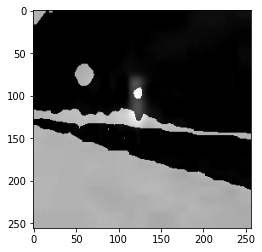

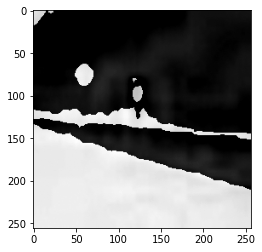

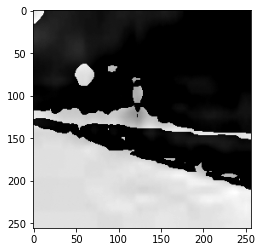

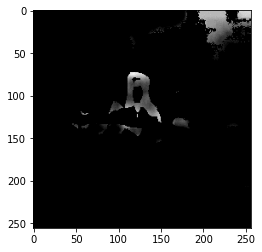

In [277]:
plt.imshow(R, 'gray')
plt.show()
plt.imshow(G, 'gray')
plt.show()
plt.imshow(B, 'gray')
plt.show()
plt.imshow(Y, 'gray')
plt.show()

# intensity map

In [278]:
i_map = intensity_map(img)

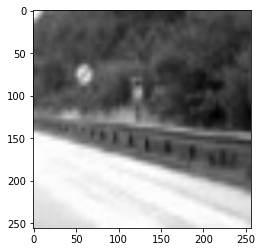

In [279]:
plt.imshow(i_map[0],'gray')

# orientation map

In [280]:
o_map = orientation_map(img)

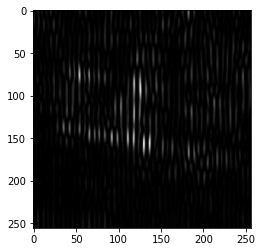

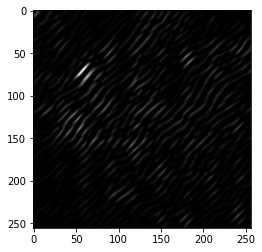

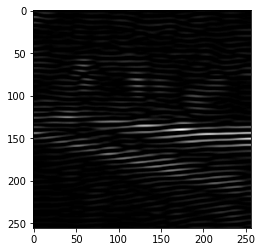

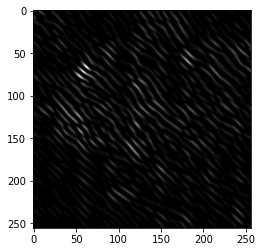

In [281]:
for i in o_map:
    plt.imshow(i, 'gray')
    plt.show()

# Gaussian pyramid

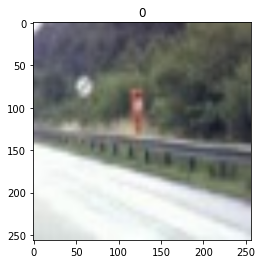

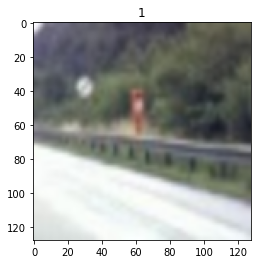

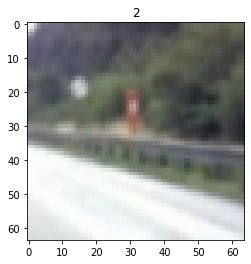

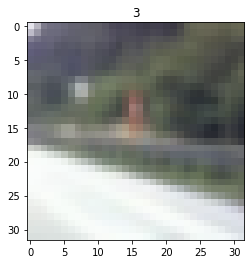

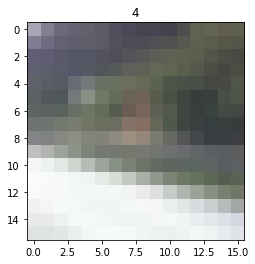

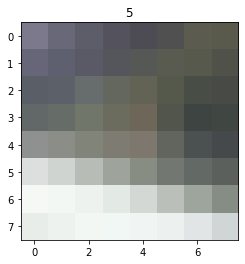

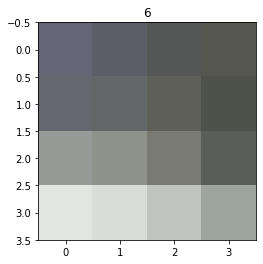

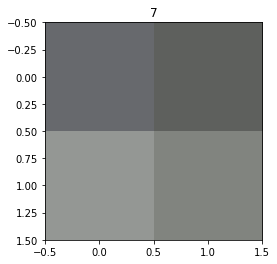

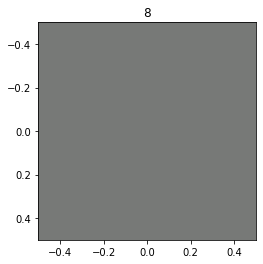

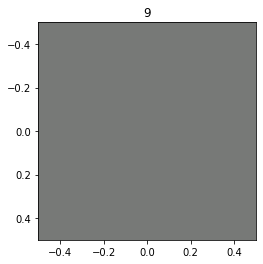

In [282]:
gpm = Gaussian_pyramid(img, 9)
for n, i in enumerate(gpm):
    plt.title(n)
    plt.imshow(i, 'gray')
    plt.show()

# feature map

In [283]:
features = extract_features(img)

<ipython-input-275-c91b74046b8d>:50: RuntimeWarning: overflow encountered in ubyte_scalars
  r = lambda r, g, b : r - (g+b)/2
<ipython-input-275-c91b74046b8d>:51: RuntimeWarning: overflow encountered in ubyte_scalars
  g = lambda r, g, b : g - (r+b)/2
<ipython-input-275-c91b74046b8d>:52: RuntimeWarning: overflow encountered in ubyte_scalars
  b = lambda r, g, b : b - (r+g)/2
<ipython-input-275-c91b74046b8d>:53: RuntimeWarning: overflow encountered in ubyte_scalars
  y = lambda r, g, b : (r+g)/2 - abs(r-g)/2 - b


In [284]:
print(len(features[0]))
print(len(features[1]))
print(len(features[2]))

2
1
4


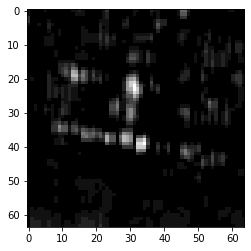

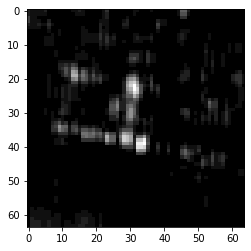

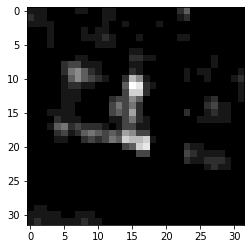

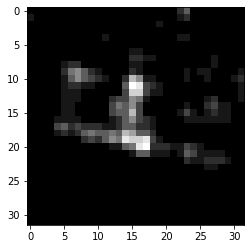

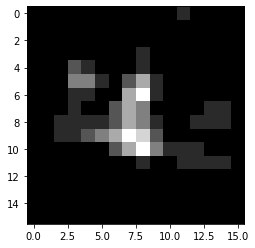

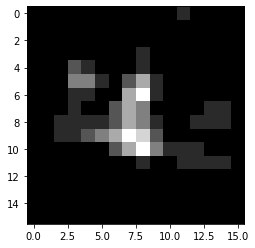

In [285]:
for i in range(6):

    plt.imshow(features[2][0][i],'gray')
    plt.show()    
        

# Normalization

-  max (local max, global max)

In [286]:
lmax, gmax = find_max(features)
print(lmax)
print(gmax)

[[52.21440124511719, 52.21440124511719, 26.988864600658417, 26.988864600658417, 13.38443682831712, 13.38443682831712], [260.3120803833008, 246.0803985595703, 246.01708281040192, 186.30277913808823, 185.15215364447795, 169.56690440198872], [124.18851725260416, 145.18851725260416, 123.68478107452393, 124.68478107452393, 116.0616268075537, 131.4874539100565], [15, 16, 11, 11, 6, 6], [12, 12, 6, 6, 3, 3], [24, 27, 14, 16, 11, 11], [6, 6, 4, 4, 1, 1]]
260.3120803833008


- feature normalization

In [287]:
C = []
I = []
O = []
norms = [C, I, O]

i = 0
for k, cio in enumerate(features):
    for feature in cio:
        norms[k].append(normalization(feature, lmax[i], gmax))
        i+=1

In [288]:
len(norms[0][0])

6

In [289]:
c_norm = norm_features(C)
i_norm = norm_features(I)
o_norm = norm_features(O)

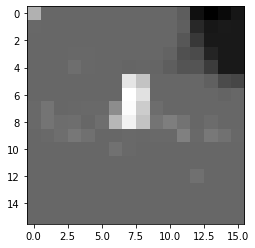

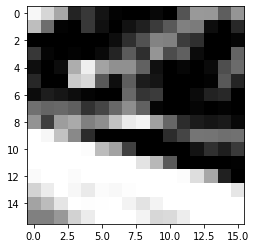

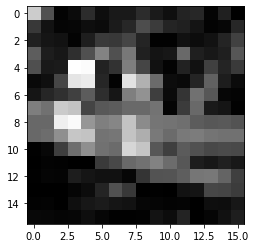

In [290]:
plt.imshow(c_norm,'gray')
plt.show()
plt.imshow(i_norm,'gray')
plt.show()
plt.imshow(o_norm,'gray')
plt.show()

# saliency map

In [291]:
saliency_map = (c_norm + i_norm + o_norm) / 3

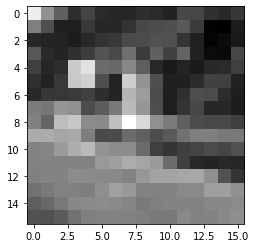

In [292]:
plt.imshow(saliency_map, 'gray')